In [1]:
import os
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd

import scipy.io

import anndata
import scanpy as sc
sc.settings.verbosity = 3

from misc import *
from bcg_utils import *
_ = setup_plotting(style='ticks', context='notebook')

In [2]:
SAVE = True
data_dir = os.path.join('..', 'data', 'scRNAseq_YangLi')

# Concat

In [ ]:
adata1 = sc.read_h5ad(os.path.join(data_dir, 'bcg0712_bcg.h5ad'))
adata2 = sc.read_h5ad(os.path.join(data_dir, 'bcg0712_T0LPS.h5ad'))
adata3 = sc.read_h5ad(os.path.join(data_dir, 'bcg0712_T3mLPS.h5ad'))
adata = adata1.concatenate(adata2, adata3, join='inner', batch_key='datafile', index_unique=None)
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
adata.write(os.path.join(data_dir, 'bcg0712_complete.h5ad'), compression='gzip')

In [ ]:
if SAVE:
    import scipy.io
    scipy.io.mmwrite(os.path.join(data_dir, 'bcg0712_complete.mtx'), adata.raw.X)

# Preprocess

In [102]:
adata = anndata.read_h5ad(os.path.join(data_dir, 'bcg0712_complete.h5ad'))
adata

AnnData object with n_obs × n_vars = 197287 × 21975
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'cells', 'age', 'gender', 'time', 'stim', 'ts', 'batch', 'pool', 'bp', 'percent.mt', 'integrated_snn_res.0.5', 'seurat_clusters', 'clusters1', 'cell_ts', 'ids', 'datafile'
    var: 'features'
    obsm: 'X_umap'

In [103]:
for ids in adata.obs['ids'].unique():
    assert len(adata.obs.loc[adata.obs['ids'] == ids, 'batch'].unique()) == 1
display(adata.obs.groupby(['ts', 'batch'])['batch'].count())

ts        batch
T0_LPS    b1       14810
          b2       13234
          b3       22573
T0_RPMI   b1       13462
          b2       15885
          b3       21954
T3m_LPS   b1       12153
          b2       13134
          b3       21118
T3m_RPMI  b1       15470
          b2       12307
          b3       21187
Name: batch, dtype: int64

In [104]:
for ids in adata.obs['ids'].unique():
    assert (adata.obs.loc[adata.obs['ids'] == ids].groupby('ts')['cells'].count() > 10).all(), ids

In [105]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment',
       'cells', 'age', 'gender', 'time', 'stim', 'ts', 'batch', 'pool', 'bp',
       'percent.mt', 'integrated_snn_res.0.5', 'seurat_clusters', 'clusters1',
       'cell_ts', 'ids', 'datafile'],
      dtype='object')

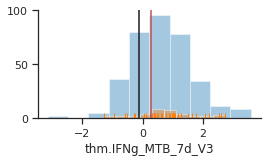

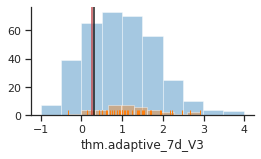

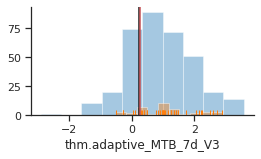

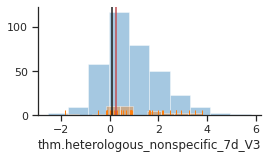

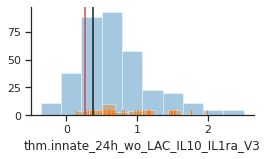

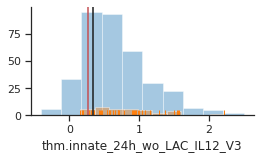

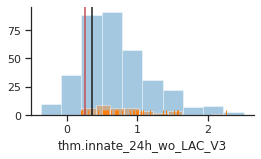

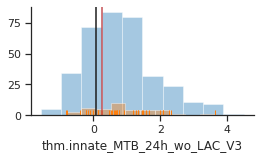

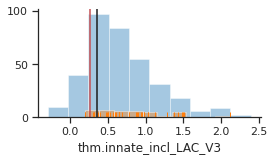

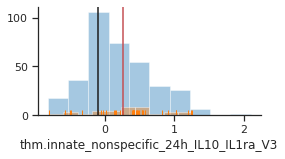

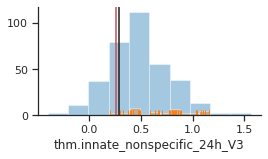

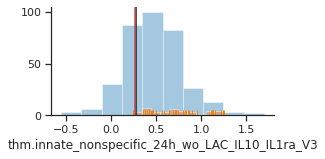

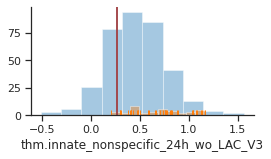

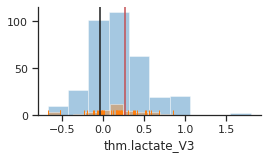

In [106]:
df = get_sample_annot()
for col in df.columns[df.columns.str.contains('^thm.*V3$')].tolist():
    pheno = df.loc[df['SAMPLE:VISIT'] == 'V3'].set_index('SAMPLE:DONOR')[col]
    _, ax = plt.subplots(1, 1, figsize=(4, 2))
    sns.distplot(pheno, kde=False, bins=10)
    sns.distplot(pheno.loc[adata.obs['ids'].unique()], hist=True, kde=False, rug=True, bins=10)
    ax.axvline(pheno.quantile(0.25), c='k')
    ax.axvline(np.log2(1.2), c='r')
    sns.despine()
    plt.show()

# Start from raw counts

In [107]:
adata.X = adata.raw.X

In [108]:
# Quality control - calculate QC covariates
adata.obs['groupby'] = (adata.obs['ids'].astype(str) + '_' + adata.obs['time'].astype(str) + '_' + adata.obs['stim'].astype(str)).astype('category')
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
adata.obs['mt_frac'] = adata.obs['percent.mt']
adata.obs.head()

orig.ident  nCount_RNA  nFeature_RNA   status  \
AAACCCAAGTCTAGAA-1_1_1     300bcg      9363.0          3268  singlet   
AAACCCACAATTTCCT-1_1_1     300bcg      8343.0          2882  singlet   
AAACGAACAGCGTTTA-1_1_1     300bcg      6959.0          2799  singlet   
AAACGAAGTCGCATGC-1_1_1     300bcg      4662.0          1832  singlet   
AAACGAATCGGAATGG-1_1_1     300bcg      8321.0          2689  singlet   

                        assignment             cells   age gender time  stim  \
AAACCCAAGTCTAGAA-1_1_1         1.0  300BCG044T0_RPMI  23.0      f   T0  RPMI   
AAACCCACAATTTCCT-1_1_1         1.0  300BCG044T0_RPMI  23.0      f   T0  RPMI   
AAACGAACAGCGTTTA-1_1_1         4.0  300BCG055T0_RPMI  24.0      f   T0  RPMI   
AAACGAAGTCGCATGC-1_1_1         4.0  300BCG055T0_RPMI  24.0      f   T0  RPMI   
AAACGAATCGGAATGG-1_1_1         1.0  300BCG044T0_RPMI  23.0      f   T0  RPMI   

                        ... seurat_clusters  clusters1            cell_ts  \
AAACCCAAGTCTAGAA-1_1_1  ...              12     CD8+ T     CD8+ T_T0_RPMI   
AAACCCACAATTTCCT-1_1_1  ...              12     CD8+ T     CD8+ T_T0_RPMI   
AAACGAACAGCGTTTA-1_1_1  ...              12     CD8+ T     CD8+ T_T0_RPMI   
AAACGAAGTCGCATGC-1_1_1  ...               2  Monocytes  Monocytes_T0_RPMI   
AAACGAATCGGAATGG-1_1_1  ...              25          B          B_T0_RPMI   

                              ids  datafile            groupby n_counts  \
AAACCCAAGTCTAGAA-1_1_1  300BCG044         0  300BCG044_T0_RPMI   9363.0   
AAACCCACAATTTCCT-1_1_1  300BCG044         0  300BCG044_T0_RPMI   8343.0   
AAACGAACAGCGTTTA-1_1_1  300BCG055         0  300BCG055_T0_RPMI   6959.0   
AAACGAAGTCGCATGC-1_1_1  300BCG055         0  300BCG055_T0_RPMI   4662.0   
AAACGAATCGGAATGG-1_1_1  300BCG044         0  300BCG044_T0_RPMI   8321.0   

                       log_counts n_genes   mt_frac  
AAACCCAAGTCTAGAA-1_1_1   9.144521    3268  5.145129  
AAACCCACAATTTCCT-1_1_1   9.029179    2882  6.944677  
AAACGAACAGCGTTTA-1_1_1   8.847791    2799  5.496966  
AAACGAAGTCGCATGC-1_1_1   8.447200    1832  4.114146  
AAACGAATCGGAATGG-1_1_1   9.026538    2689  5.035550  

[5 rows x 26 columns]

the obs value 'groupby' has more than 103 categories. Uniform 'grey' color will be used for all categories.


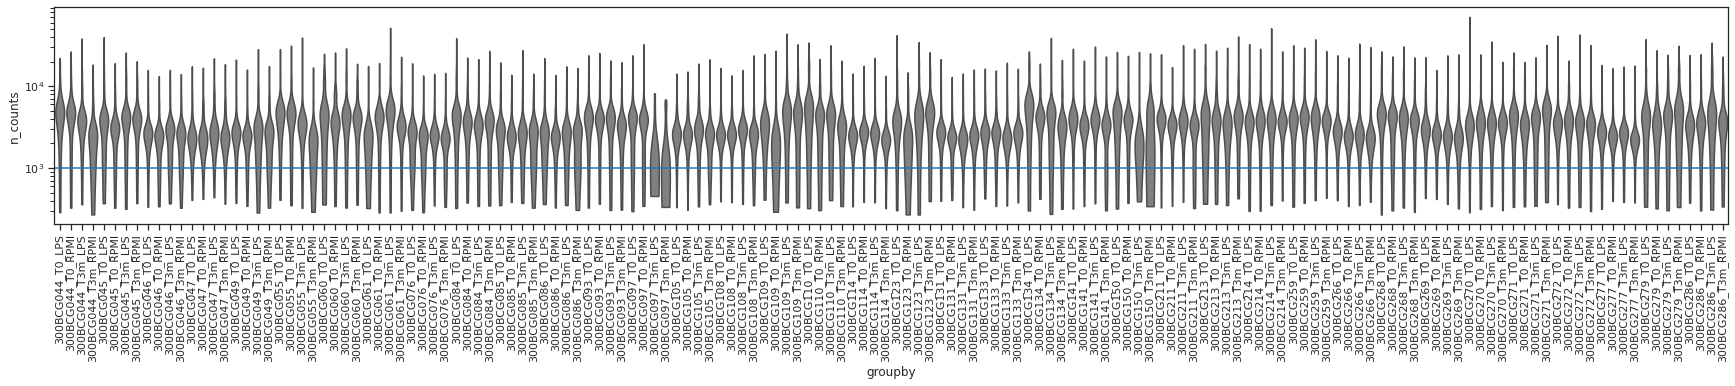

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4))
ax = sc.pl.violin(adata, 'n_counts', groupby='groupby', size=2, log=True, cut=0, show=False, stripplot=False, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.axhline(1000)
plt.show()

In [110]:
for ids in adata.obs['ids'].unique():
    if (adata.obs.loc[adata.obs['ids'] == ids].groupby('ts')['cells'].count() < 100).any():
        display(adata.obs.loc[adata.obs['ids'] == ids].groupby('ts')['cells'].count())

ts
T0_LPS       964
T0_RPMI     1067
T3m_LPS       45
T3m_RPMI      51
Name: cells, dtype: int64

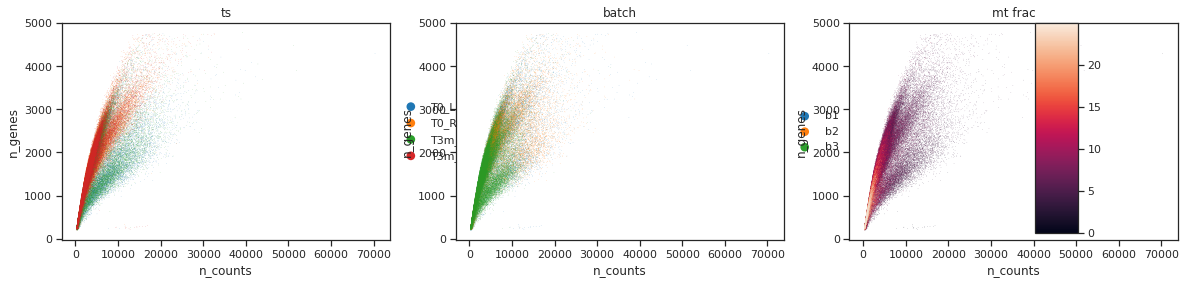

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
ax = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='ts', show=False, ax=axs[0])
ax = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='batch', show=False, ax=axs[1])
ax = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', show=False, ax=axs[2])
plt.show()

In [112]:
MIN_COUNTS = 1000
MAX_COUNTS = 30000
MT_FRAC = 25
adata.obs['high_mt_frac'] = adata.obs['mt_frac'] >= MT_FRAC
MIN_GENES = 700
MIN_CELLS = 10

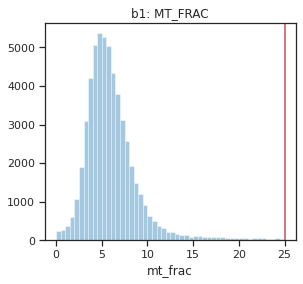

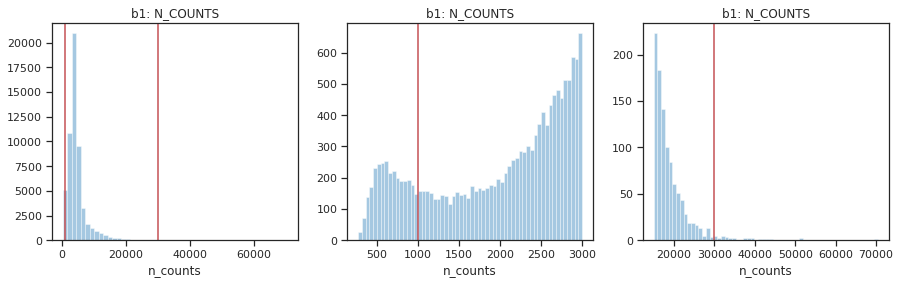

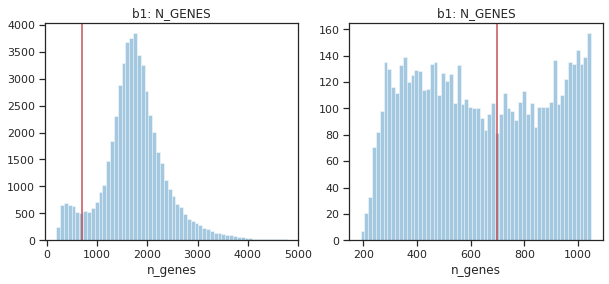

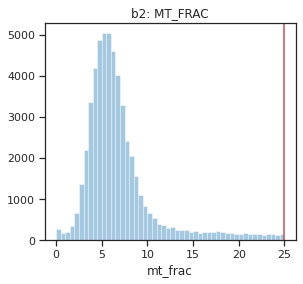

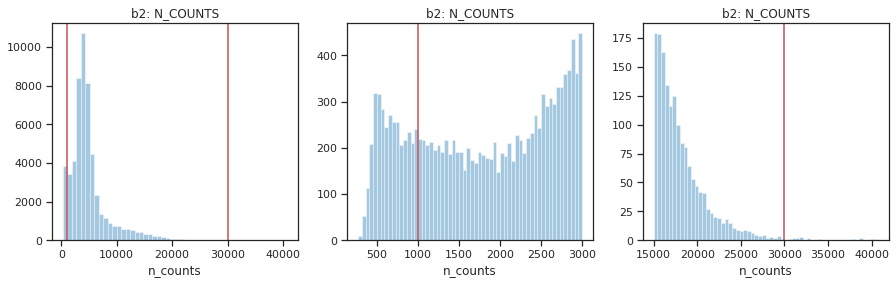

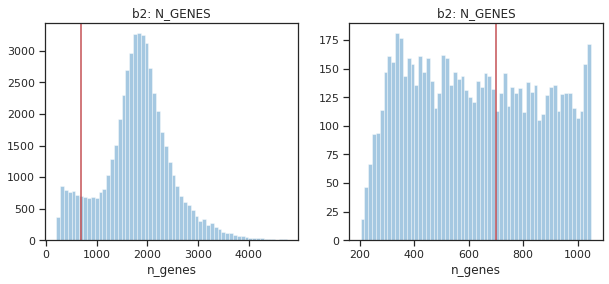

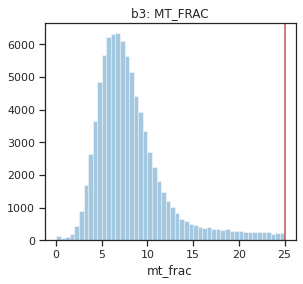

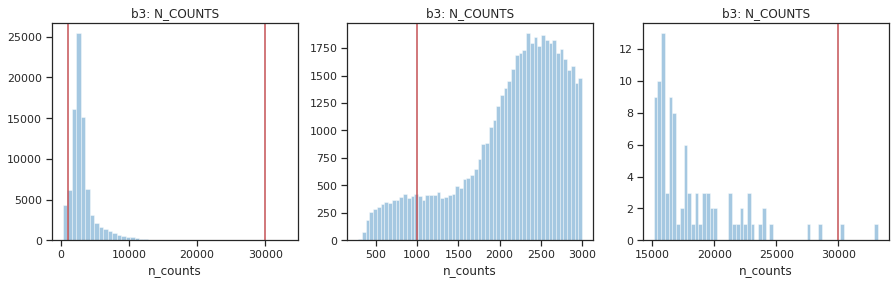

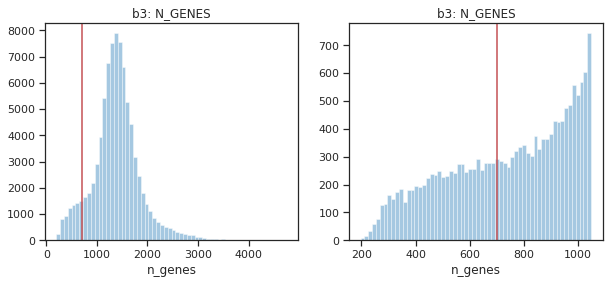

In [113]:
BY_COLUMN = 'batch'
for ts in adata.obs[BY_COLUMN].unique():
    ad = adata[adata.obs[BY_COLUMN] == ts]
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
    ax = sns.distplot(ad.obs['mt_frac'], kde=False, ax=ax)
    ax.axvline(MT_FRAC, color='r')
    ax.set_title(f'{ts}: MT_FRAC')
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    ax = sns.distplot(ad.obs['n_counts'], kde=False, ax=axs[0])
    ax.axvline(MIN_COUNTS, color='r')
    ax.axvline(MAX_COUNTS, color='r')
    ax.set_title(f'{ts}: N_COUNTS')

    ax = sns.distplot(ad.obs['n_counts'][ad.obs['n_counts'] < MIN_COUNTS * 3], kde=False, bins=60, ax=axs[1])
    ax.axvline(MIN_COUNTS, color='r')
    ax.set_title(f'{ts}: N_COUNTS')

    ax = sns.distplot(ad.obs['n_counts'][ad.obs['n_counts'] > MAX_COUNTS / 2], kde=False, bins=60, ax=axs[2])
    ax.axvline(MAX_COUNTS, color='r')
    ax.set_title(f'{ts}: N_COUNTS')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    ax = sns.distplot(ad.obs['n_genes'], kde=False, bins=60, ax=axs[0])
    ax.axvline(MIN_GENES, color='r')
    ax.set_title(f'{ts}: N_GENES')

    ax = sns.distplot(ad.obs['n_genes'][ad.obs['n_genes'] < MIN_GENES * 1.5], kde=False, bins=60, ax=axs[1])
    ax.axvline(MIN_GENES, color='r')
    ax.set_title(f'{ts}: N_GENES')
    plt.show()

In [114]:
for ts in adata.obs['ts'].unique():
    print(f'{ts}: Number of cells BEFORE filtering: {(adata.obs["ts"] == ts).sum()}')

T0_RPMI: Number of cells BEFORE filtering: 51301
T3m_RPMI: Number of cells BEFORE filtering: 48964
T0_LPS: Number of cells BEFORE filtering: 50617
T3m_LPS: Number of cells BEFORE filtering: 46405


In [115]:
sc.pp.filter_cells(adata, min_counts=MIN_COUNTS)
for ts in adata.obs['ts'].unique():
    print(f'{ts}: Number of cells after MIN_COUNT filter of {MIN_COUNTS}: {(adata.obs["ts"] == ts).sum()}')
print('--')
sc.pp.filter_cells(adata, max_counts=MAX_COUNTS)
for ts in adata.obs['ts'].unique():
    print(f'{ts}: Number of cells after MAX_COUNT filter of {MAX_COUNTS}: {(adata.obs["ts"] == ts).sum()}')
print('--')
adata = adata[adata.obs['mt_frac'] < MT_FRAC]
for ts in adata.obs['ts'].unique():
    print(f'{ts}: Number of cells after MT_FRAC filter of {MT_FRAC}: {(adata.obs["ts"] == ts).sum()}')
print('--')
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
for ts in adata.obs['ts'].unique():
    print(f'{ts}: Number of cells after MIN_GENES filter of {MIN_GENES}: {(adata.obs["ts"] == ts).sum()}')

filtered out 11148 cells that have less than 1000 counts


T0_RPMI: Number of cells after MIN_COUNT filter of 1000: 48566
T3m_RPMI: Number of cells after MIN_COUNT filter of 1000: 45663
T0_LPS: Number of cells after MIN_COUNT filter of 1000: 48066
T3m_LPS: Number of cells after MIN_COUNT filter of 1000: 43844
--


filtered out 52 cells that have more than 30000 counts


T0_RPMI: Number of cells after MAX_COUNT filter of 30000: 48564
T3m_RPMI: Number of cells after MAX_COUNT filter of 30000: 45656
T0_LPS: Number of cells after MAX_COUNT filter of 30000: 48048
T3m_LPS: Number of cells after MAX_COUNT filter of 30000: 43819
--
T0_RPMI: Number of cells after MT_FRAC filter of 25: 48564
T3m_RPMI: Number of cells after MT_FRAC filter of 25: 45656
T0_LPS: Number of cells after MT_FRAC filter of 25: 48048
T3m_LPS: Number of cells after MT_FRAC filter of 25: 43819
--


filtered out 4194 cells that have less than 700 genes expressed
Trying to set attribute `.obs` of view, copying.


T0_RPMI: Number of cells after MIN_GENES filter of 700: 47755
T3m_RPMI: Number of cells after MIN_GENES filter of 700: 44746
T0_LPS: Number of cells after MIN_GENES filter of 700: 46767
T3m_LPS: Number of cells after MIN_GENES filter of 700: 42625


In [116]:
adata.var['n_cells'] = np.asarray((adata.X > 0).sum(axis=0)).squeeze()
adata.var.sort_values('n_cells')

features  n_cells
MALL              MALL        0
MAOB              MAOB        0
AL603832.2  AL603832.2        1
AC112254.1  AC112254.1        1
AL353572.4  AL353572.4        1
...                ...      ...
FTH1              FTH1   181138
EEF1A1          EEF1A1   181511
HLA-B            HLA-B   181612
MALAT1          MALAT1   181806
B2M                B2M   181874

[21975 rows x 2 columns]

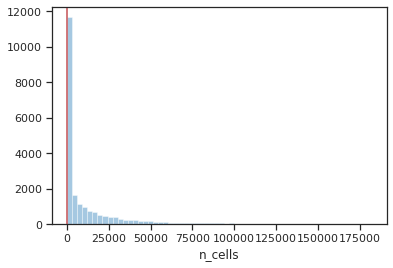

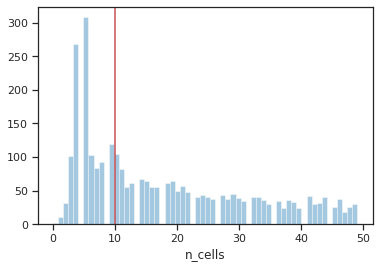

In [117]:
ax = sns.distplot(adata.var['n_cells'], kde=False, bins=60)
ax.axvline(MIN_CELLS, color='r')
plt.show()

ax = sns.distplot(adata.var['n_cells'][adata.var['n_cells'] < MIN_CELLS * 5], kde=False, bins=60)
ax.axvline(MIN_CELLS, color='r')
plt.show()

In [118]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print('Number of genes after cell filter of {}: {}'.format(MIN_CELLS, adata.n_vars))

Total number of genes: 21975


filtered out 1119 genes that are detected in less than 10 cells


Number of genes after cell filter of 10: 20856


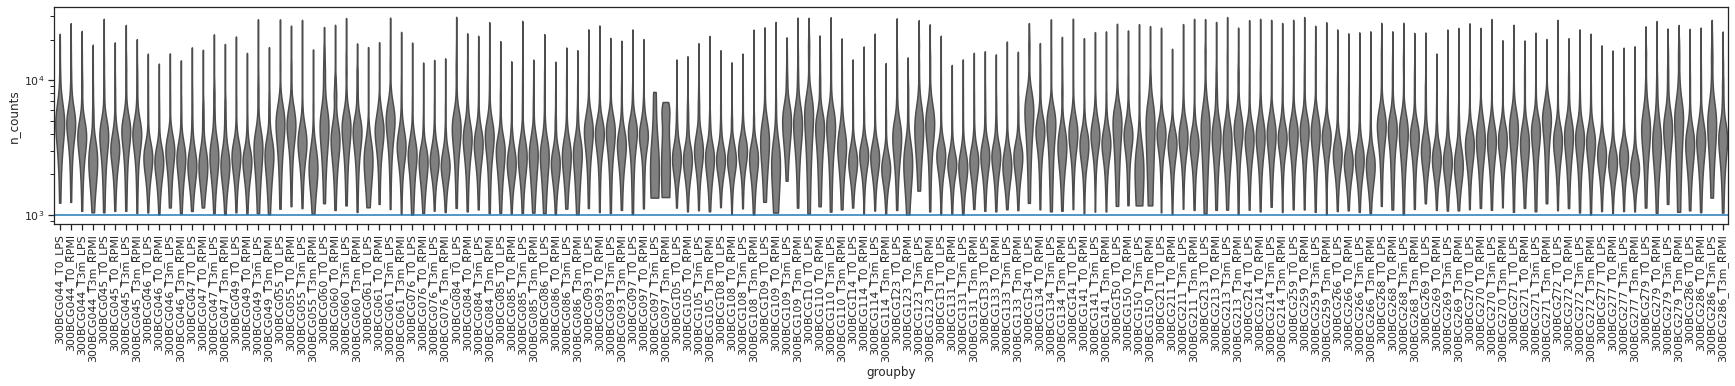

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4))
ax = sc.pl.violin(adata, 'n_counts', groupby='groupby', size=2, log=True, cut=0, show=False, stripplot=False, ax=ax)
ax.tick_params(axis='x', labelrotation=90)
ax.axhline(1000)
plt.show()

Text(0.5, 1.0, 'Cell count per sample')

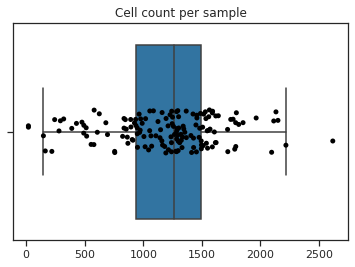

In [120]:
counts_per_sample = adata.obs.groupby(['ids', 'ts'])['time'].count().values
sns.boxplot(counts_per_sample, fliersize=0)
ax = sns.stripplot(counts_per_sample, color='black')
ax.set_title('Cell count per sample')

In [22]:
for ids in adata.obs['ids'].unique():
    cell_counts = adata.obs.loc[adata.obs['ids'] == ids].groupby('ts')['cells'].count()
    if (cell_counts < 100).any():
        display(cell_counts.rename(ids))
        
cell_counts = adata.obs.groupby(['ids', 'ts'])['cells'].count().sort_values()
idx = cell_counts.index[cell_counts < 100]
display(idx)

to_drop = adata.obs.reset_index(drop=False).set_index(['ids', 'ts']).loc[idx, 'index']
display(to_drop)

adata = adata[~adata.obs.index.isin(to_drop.values)]
adata

ts
T0_LPS      863
T0_RPMI     950
T3m_LPS      19
T3m_RPMI     19
Name: 300BCG097, dtype: int64

MultiIndex([('300BCG097',  'T3m_LPS'),
            ('300BCG097', 'T3m_RPMI')],
           names=['ids', 'ts'])

ids        ts      
300BCG097  T3m_LPS     AGGTGTTGTTGGCCGT-1_2_2
           T3m_LPS     AGTCACAAGCGACAGT-1_2_2
           T3m_LPS     ATCATTCAGCGTTGTT-1_2_2
           T3m_LPS     CACCAAAGTATTTCTC-1_2_2
           T3m_LPS     CAGTTAGTCCCGTAAA-1_2_2
           T3m_LPS     CCATCACGTAGTTAGA-1_2_2
           T3m_LPS     CCTCACATCTACCACC-1_2_2
           T3m_LPS     CGCAGGTGTATTGAGA-1_2_2
           T3m_LPS     CTGGACGAGGTTATAG-1_2_2
           T3m_LPS     GATGGAGCAGACATCT-1_2_2
           T3m_LPS     GATTTCTAGGATAATC-1_2_2
           T3m_LPS     GCGGATCTCCCATGGG-1_2_2
           T3m_LPS     GCTTTCGGTAGGTTTC-1_2_2
           T3m_LPS     TAACTTCAGCCTGGAA-1_2_2
           T3m_LPS     TACAACGAGCAGTCTT-1_2_2
           T3m_LPS     TACGGGCCATTCAGCA-1_2_2
           T3m_LPS     TGCTCGTGTCTCACAA-1_2_2
           T3m_LPS     TGTCAGAAGGTTTGAA-1_2_2
           T3m_LPS     TTCACGCCACAGCTGC-1_2_2
           T3m_RPMI    AAAGGTAGTATACGGG-1_1_2
           T3m_RPMI    ACCATTTAGTAGCCAG-1_1_2
           T3m

View of AnnData object with n_obs × n_vars = 181855 × 20856
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'cells', 'age', 'gender', 'time', 'stim', 'ts', 'batch', 'pool', 'bp', 'percent.mt', 'integrated_snn_res.0.5', 'seurat_clusters', 'clusters1', 'cell_ts', 'ids', 'datafile', 'groupby', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'high_mt_frac'
    var: 'features', 'n_cells'
    uns: 'groupby_colors', 'ts_colors', 'batch_colors'
    obsm: 'X_umap'

In [23]:
display(adata.obs.loc[(adata.obs['ids']=='300BCG097') & (adata.obs['ts']=='T3m_RPMI')])
display(adata.obs.loc[(adata.obs['ids']=='300BCG097') & (adata.obs['ts']=='T3m_LPS')])

Empty DataFrame
Columns: [orig.ident, nCount_RNA, nFeature_RNA, status, assignment, cells, age, gender, time, stim, ts, batch, pool, bp, percent.mt, integrated_snn_res.0.5, seurat_clusters, clusters1, cell_ts, ids, datafile, groupby, n_counts, log_counts, n_genes, mt_frac, high_mt_frac]
Index: []

[0 rows x 27 columns]

Empty DataFrame
Columns: [orig.ident, nCount_RNA, nFeature_RNA, status, assignment, cells, age, gender, time, stim, ts, batch, pool, bp, percent.mt, integrated_snn_res.0.5, seurat_clusters, clusters1, cell_ts, ids, datafile, groupby, n_counts, log_counts, n_genes, mt_frac, high_mt_frac]
Index: []

[0 rows x 27 columns]

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.leiden(adata, resolution=2, key_added='low_level_leiden')
sc.tl.umap(adata)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:02:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
running Leiden clustering


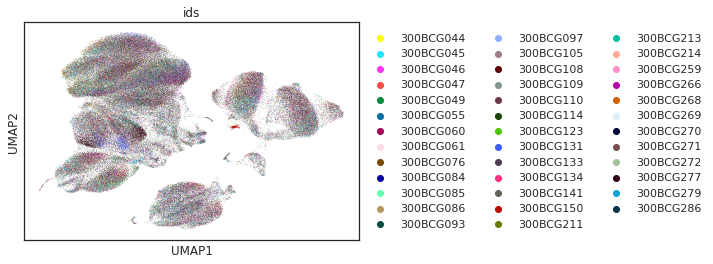

In [26]:
sc.pl.umap(adata, color='ids')

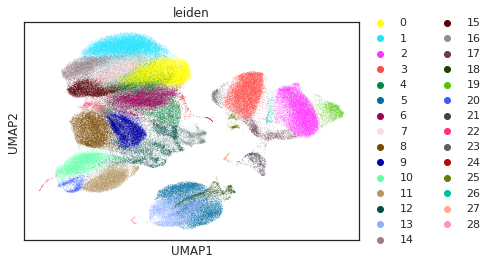

In [27]:
sc.pl.umap(adata, color='leiden')

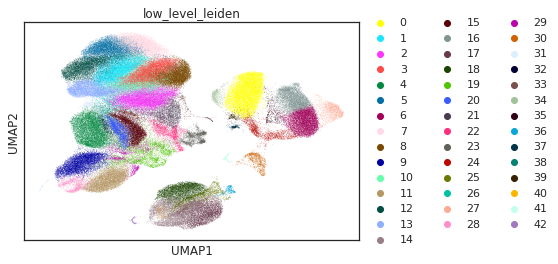

In [32]:
sc.pl.umap(adata, color='low_level_leiden')

37: 409


... storing 'LLL' as categorical


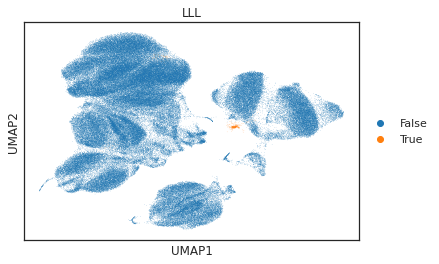

39: 296


... storing 'LLL' as categorical


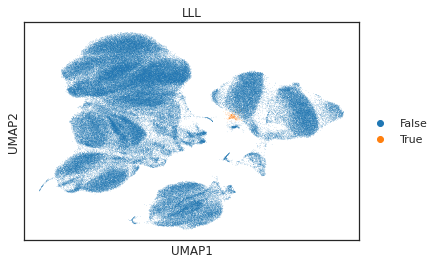

In [36]:
for ct in ['37', '39']:
    cts = (adata.obs['low_level_leiden'] == ct)
    adata.obs['LLL'] = (cts).astype(str)
    print(f'{ct}: {cts.sum()}')
    sc.pl.umap(adata, color='LLL')
    plt.show()
    
adata.obs.drop('LLL', axis=1, inplace=True)

37 0.5916870415647921 -- 409 cells
39 0.07432432432432433 -- 296 cells


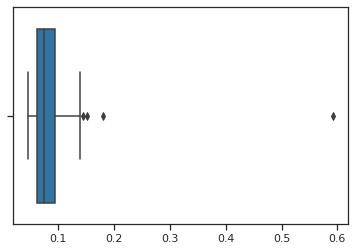

In [53]:
highest_single_donor_fraction = {ct: (adata.obs.loc[adata.obs['low_level_leiden'] == ct].groupby('ids')['cells'].count() / (adata.obs['low_level_leiden'] == ct).sum()).max() for ct in adata.obs['low_level_leiden'].unique()}
sns.boxplot(list(highest_single_donor_fraction.values()))
for ct in ['37', '39']:
    print(ct, highest_single_donor_fraction[ct], '--', (adata.obs['low_level_leiden'] == ct).sum(), 'cells')

In [55]:
if SAVE:
    adata.var.to_csv(os.path.join(data_dir, 'bcg0712_complete.QC2.inclCluster37.var.csv'))
    adata.obs.to_csv(os.path.join(data_dir, 'bcg0712_complete.QC2.inclCluster37.obs.csv'))
    scipy.io.mmwrite(os.path.join(data_dir, 'bcg0712_complete.QC2.inclCluster37.raw.mtx'), adata.raw.X)
    adata.write(os.path.join(data_dir, 'bcg0712_complete.QC2.inclCluster37.h5ad'), compression='gzip')

In [59]:
print(adata.shape)
adata = adata[adata.obs['low_level_leiden'] != '37']
print(adata.shape)

(181855, 20856)
(181446, 20856)


In [101]:
var_names = adata.var_names
obs_names = adata.obs_names

In [ ]:
# reload from the beginning and then subset:

In [ ]:
assert len(adata.var_names) > var_names
assert len(adata.obs_names) > obs_names

In [124]:
adata = adata[adata.obs_names.isin(obs_names), adata.var_names.isin(var_names)]

In [131]:
assert adata.X.sum(axis=0).min() < MIN_CELLS
assert adata.obs.loc[(adata.obs['ids']=='300BCG097') & (adata.obs['ts']=='T3m_RPMI')].shape[0] == 0
assert adata.obs.loc[(adata.obs['ids']=='300BCG097') & (adata.obs['ts']=='T3m_LPS')].shape[0] == 0

In [128]:
if SAVE:
    adata.write(os.path.join(data_dir, 'bcg0712_complete.QC2.h5ad'), compression='gzip')
    adata.var.to_csv(os.path.join(data_dir, 'bcg0712_complete.QC2.var.csv'))
    adata.obs.to_csv(os.path.join(data_dir, 'bcg0712_complete.QC2.obs.csv'))
    scipy.io.mmwrite(os.path.join(data_dir, 'bcg0712_complete.QC2.mtx'), adata.X)

# More visual analysis

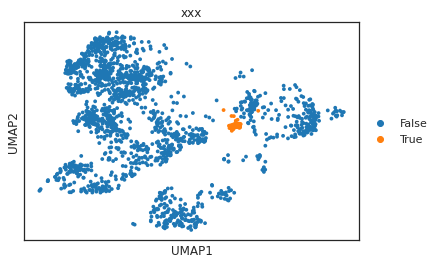

In [44]:
sc.pl.umap(adata[(adata.obs['ids'] == '300BCG150')], color='xxx')

300BCG044: 4169


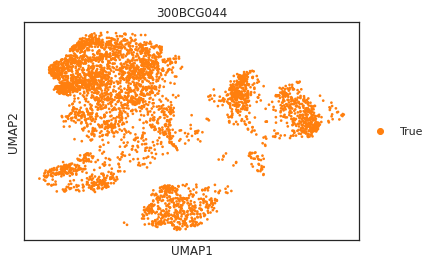

300BCG055: 3541


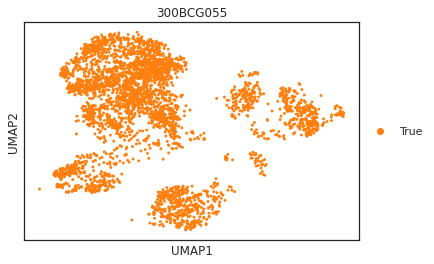

300BCG061: 3560


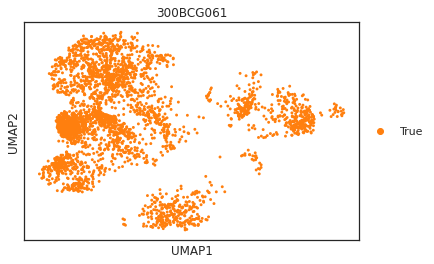

300BCG123: 3215


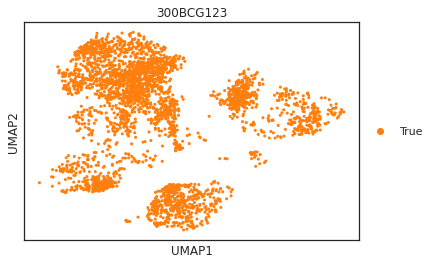

300BCG109: 1497


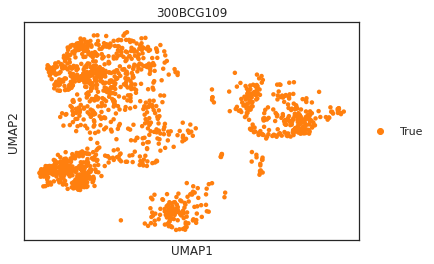

300BCG259: 5182


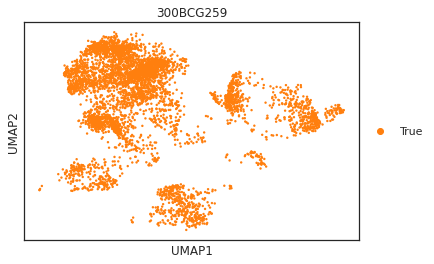

300BCG214: 4767


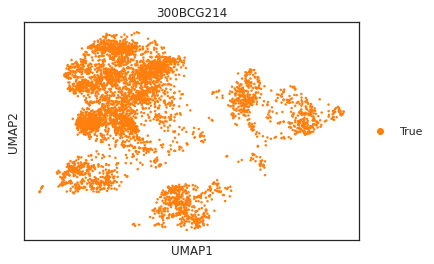

300BCG141: 6438


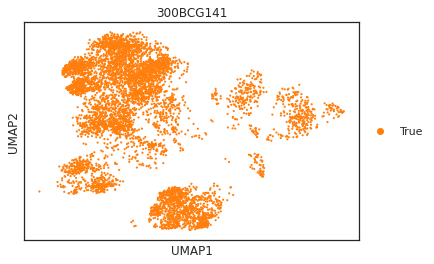

300BCG211: 5320


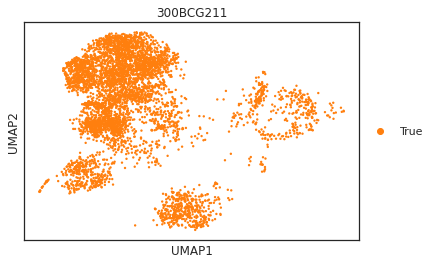

300BCG270: 5028


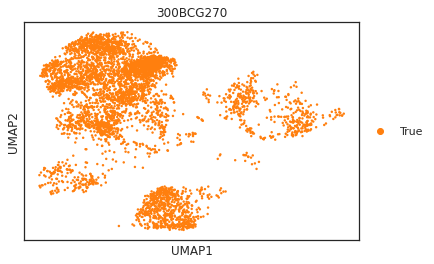

300BCG286: 3424


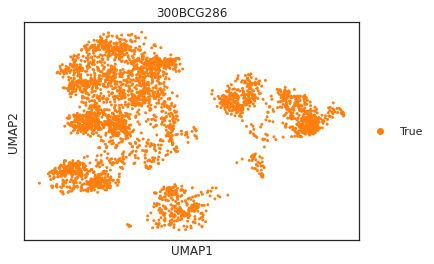

300BCG272: 5980


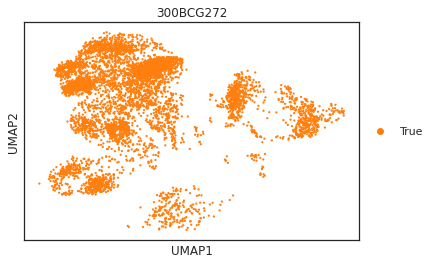

300BCG045: 7505


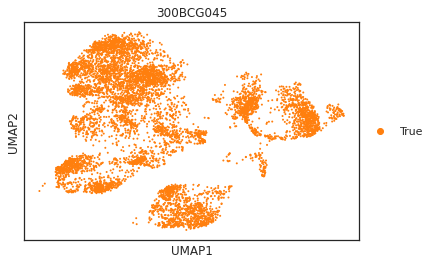

300BCG060: 3773


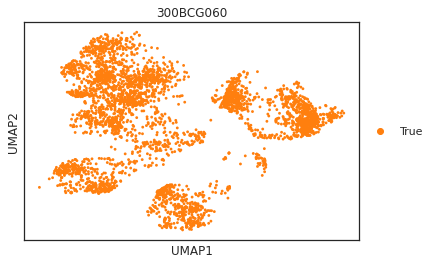

300BCG084: 4362


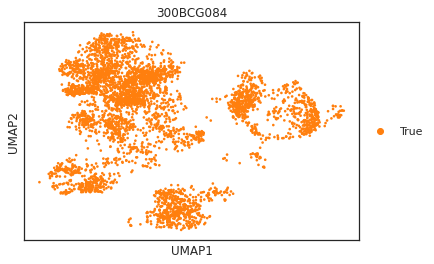

300BCG093: 3555


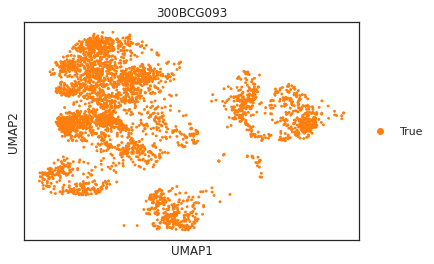

300BCG097: 1813


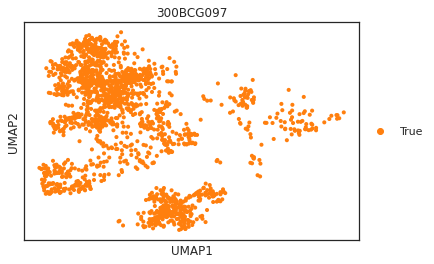

300BCG134: 4485


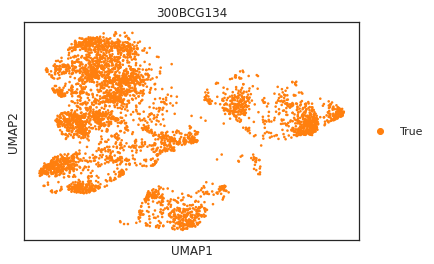

300BCG268: 5831


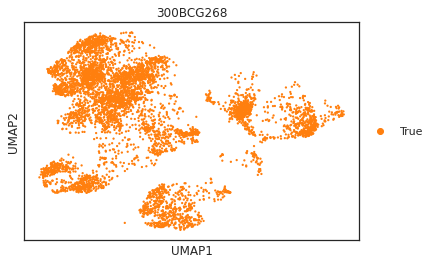

300BCG110: 3299


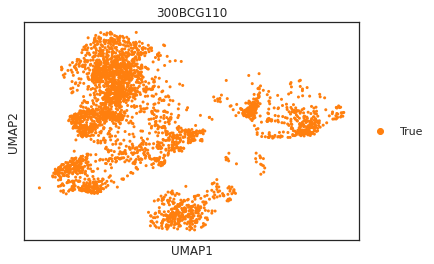

300BCG150: 2084


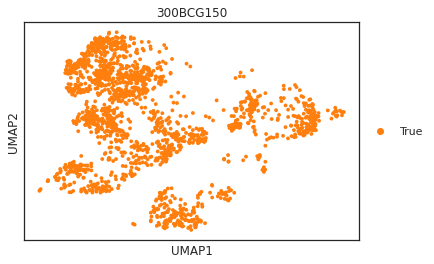

300BCG213: 5076


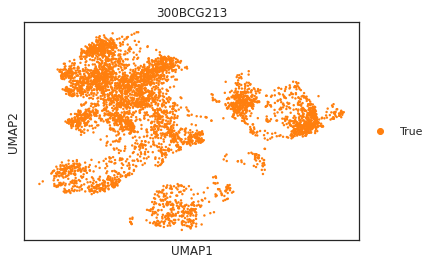

300BCG279: 3775


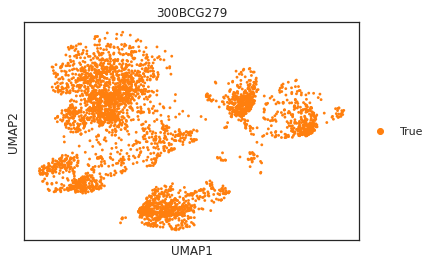

300BCG271: 4250


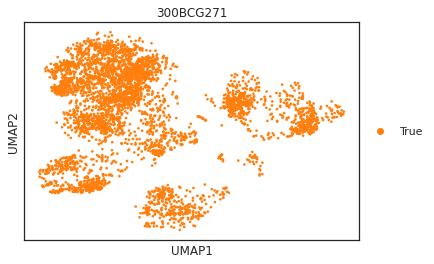

300BCG049: 6476


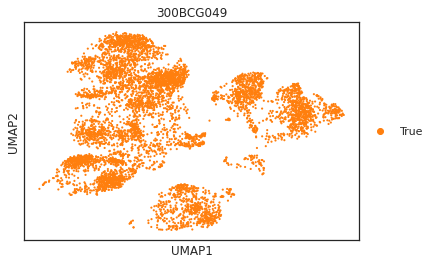

300BCG046: 5483


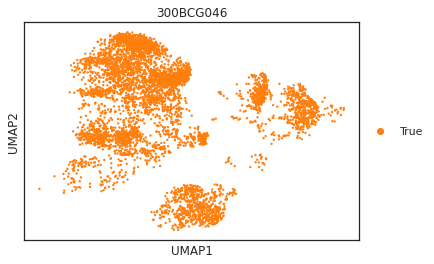

300BCG086: 3942


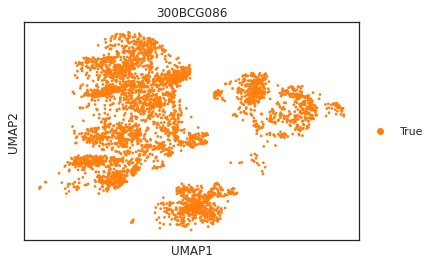

300BCG085: 4958


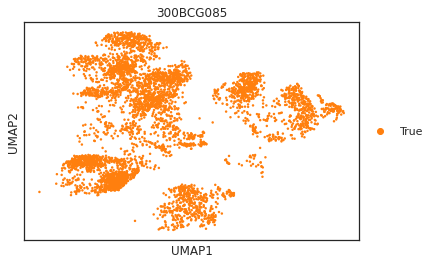

300BCG076: 4780


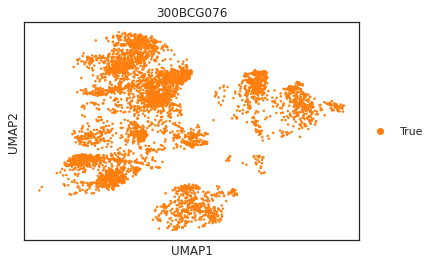

300BCG131: 5686


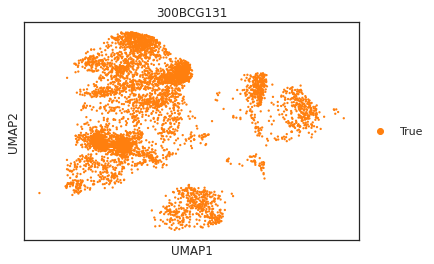

300BCG133: 5306


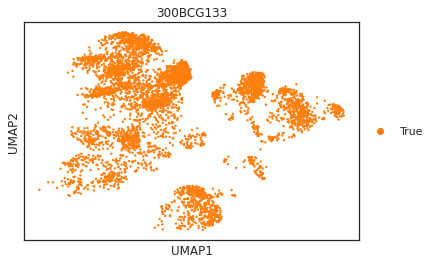

300BCG105: 6779


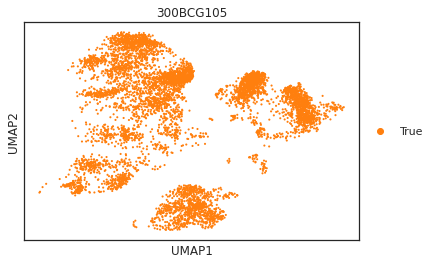

300BCG108: 6272


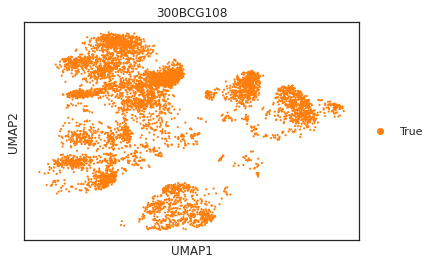

300BCG266: 5870


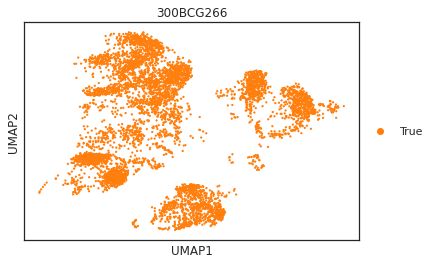

300BCG277: 6542


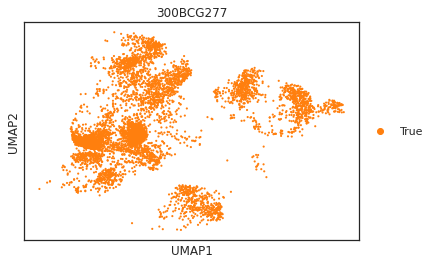

300BCG269: 5462


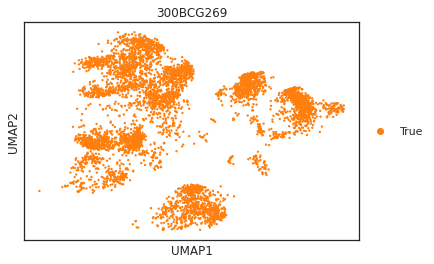

300BCG114: 7022


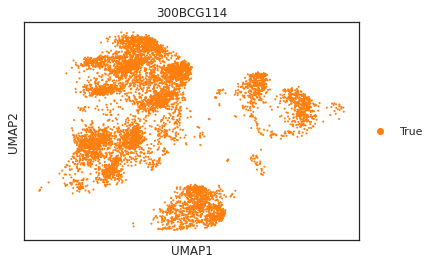

300BCG047: 5348


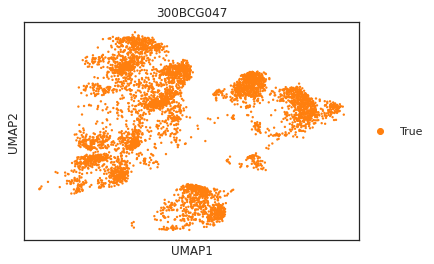

In [17]:
for idx in adata.obs['ids'].unique():
    mask = (adata.obs['ids'] == idx)
    adata.obs[idx] = pd.Series((mask).astype(str), index=adata.obs.index).astype('category')
    
for idx in adata.obs['ids'].unique():
    mask = (adata.obs['ids'] == idx)
    print(f'{idx}: {mask.sum()}')
    sc.pl.umap(adata[adata.obs[idx] == 'True'], color=idx)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


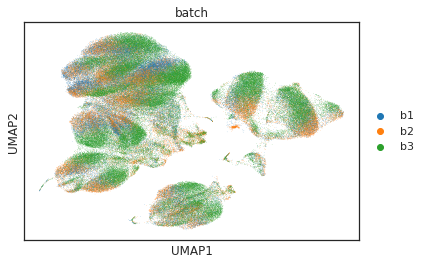

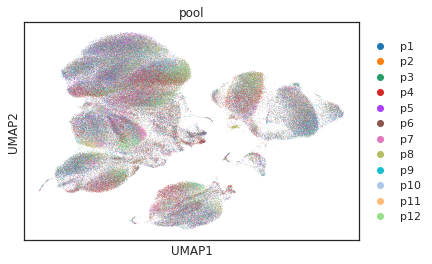

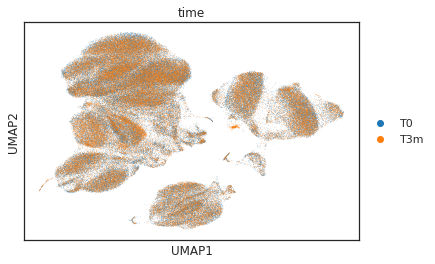

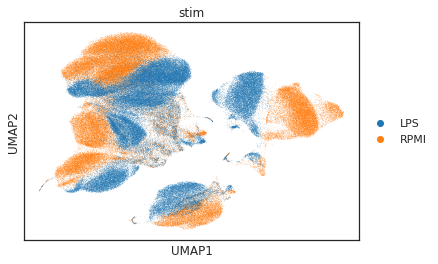

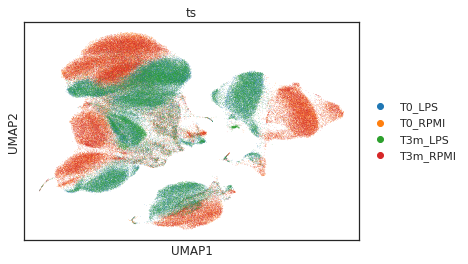

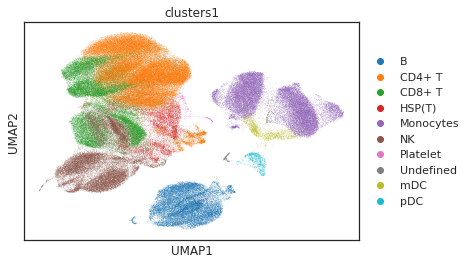

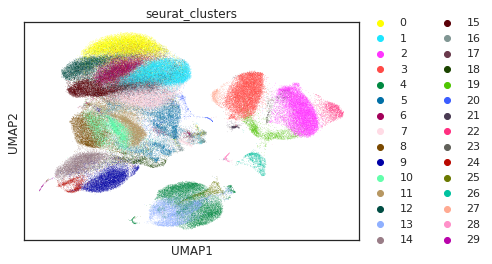

In [5]:
for color in ['batch', 'pool', 'time', 'stim', 'ts', 'clusters1', 'seurat_clusters']:
    sc.pl.umap(adata, color=color)
    plt.show()

# Preprocessed by Li Group

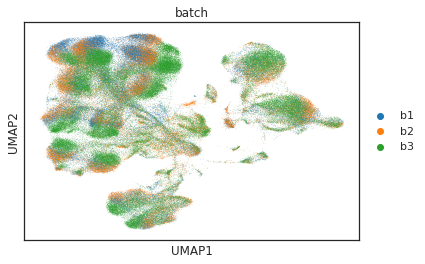

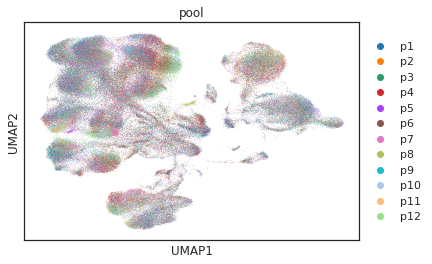

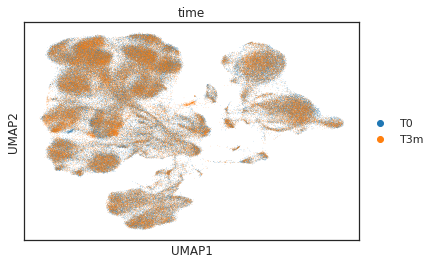

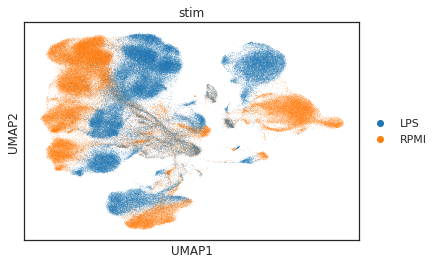

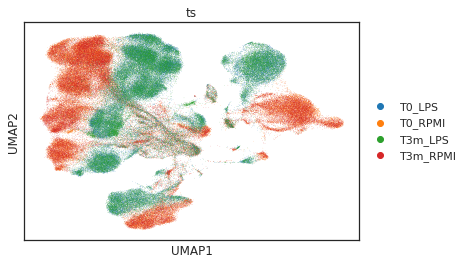

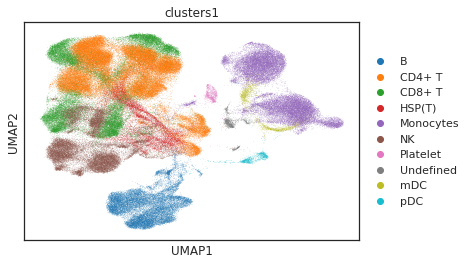

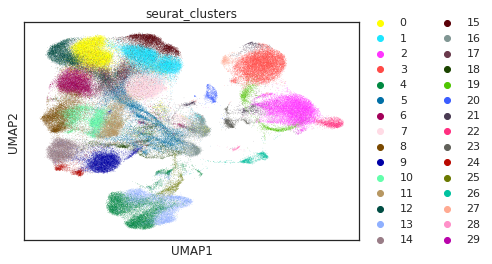

In [46]:
for color in ['batch', 'pool', 'time', 'stim', 'ts', 'clusters1', 'seurat_clusters']:
    sc.pl.umap(adata, color=color)
    plt.show()